# Stock Price Prediction using Machine Learning in Python 


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# BASIC EDA(Exploratory Data Analysis)

In [3]:
df = pd.read_csv("Tesla.csv")
df

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
1687,3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400,262.049988


In [4]:
df.shape

(1692, 7)

In [5]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [9]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

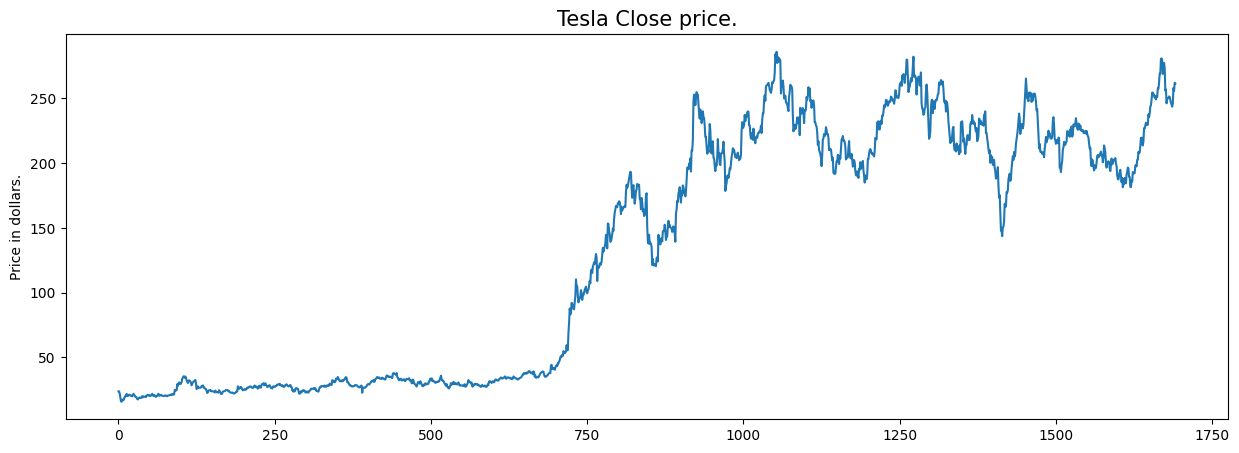

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Tesla Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

# Feature Engineering 

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df['Return_1'] = df['Adj Close'].pct_change(1)
df['SMA_5'] = df['Adj Close'].rolling(5).mean()
df['SMA_10'] = df['Adj Close'].rolling(10).mean()
df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['RSI'] = 100 - (100 / 
    (1 + df['Return_1'].clip(lower=0).ewm(span=14).mean() / 
    (-df['Return_1'].clip(upper=0).ewm(span=14).mean()).abs())
)

df['Volatility_10'] = df['Return_1'].rolling(10).std()
df['Lag_1'] = df['Adj Close'].shift(1)
df['Lag_2'] = df['Adj Close'].shift(2)
df['Lag_3'] = df['Adj Close'].shift(3)

In [13]:
df.dropna(inplace=True)

# Model Building

In [14]:
features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'SMA_5', 'SMA_10', 'EMA_12', 'EMA_26',
            'MACD', 'RSI', 'Volatility_10',
            'Lag_1', 'Lag_2', 'Lag_3']
target = 'Adj Close'
X = df[features]
y = df[target].shift(-1)  # next-day prediction target
df = df.iloc[:-1]         # align features and labels
X = X.iloc[:-1]
y = y.iloc[:-1]

In [15]:
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Feature scaling

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
np.amax(X_train_scaled[1])

np.float64(3.821318327304082)

# Model Evaluation

In [27]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
y_pred = model.predict(X_test_scaled)

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
direction_acc = (np.sign(np.diff(y_test)) == np.sign(np.diff(y_pred))).mean() * 100

print("========== MODEL PERFORMANCE ==========")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Directional Accuracy: {direction_acc:.2f}%")
print("========================================")

========== MODEL PERFORMANCE ==========
RMSE: 5.6356
MAE: 4.1641
Directional Accuracy: 47.92%


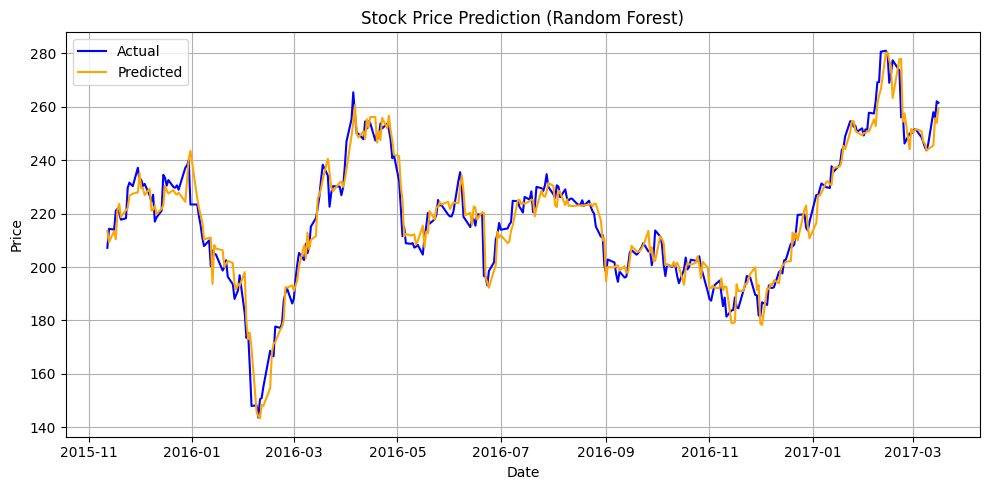

In [31]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'].iloc[split:], y_test, label='Actual', color='blue')
plt.plot(df['Date'].iloc[split:], y_pred, label='Predicted', color='orange')
plt.title('Stock Price Prediction (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
# Convert to numpy arrays (for safety)
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

# Define direction (up = 1, down = 0)
actual_dir = np.where(np.diff(y_test_np) >= 0, 1, 0)
pred_dir = np.where(np.diff(y_pred_np) >= 0, 1, 0)

In [33]:
tolerance = 0.1  # ±5% range
   # 2% tolerance (change to 0.05 for 5%)
within_range = np.abs(y_pred - y_test) / y_test <= tolerance
close_accuracy = within_range.mean() * 100
print(f"Closeness Accuracy (within ±{tolerance*100:.0f}%): {close_accuracy:.2f}%")

Closeness Accuracy (within ±10%): 99.41%


# ----------------------------------------END----------------------------------------